# Setting up

In [1]:
import pandas as pd
# Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from matplotlib.colors import hex2color, rgb2hex,LinearSegmentedColormap, ListedColormap
import seaborn as sns
import datetime
import json
import numpy as np
from scipy import stats
#import networkx as nx
import os
#from causalimpact import CausalImpact
#from sklearn.preprocessing import normalize

In [2]:
# Main color for the plot
main_color_hex = '#1b1c3a'
main_color = hex2color(main_color_hex)
second_color_hex = '#ffcc03'
second_color = hex2color(second_color_hex)

colors = [main_color, 'white', second_color] # first color is black, last is red
#colors = [main_color, second_color] # first color is black, last is red

edmo_divert = LinearSegmentedColormap.from_list(
        "EDMO_divert", colors, N=40)
edmo_cat = ListedColormap(edmo_divert(np.linspace(0, 1, 15)), N=10)
edmo_cat.name = 'EDMO_cat'
mpl.colormaps.register(edmo_divert)
mpl.colormaps.register(edmo_cat)

sns_color_palette_cat = sns.color_palette('tab20')
#sns_color_palette_cat = sns.color_palette('EDMO_divert')
sns.set_style("white")
# Size of the figure to match the latex document

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "figure.figsize" : (4.5, 4),
    "font.size":    11.0,
    'legend.fontsize' : 8,
    'xtick.labelsize' : 9,
    'ytick.labelsize' : 9

})


In [3]:
sns_color_palette_cat = sns.color_palette('EDMO_divert')#[::-1]

In [4]:
# Mkdir folder for plots if not existing
folder_plots_eps = './plots/selected_plots/eps/'
os.makedirs(folder_plots_eps, exist_ok=True)
folder_plots_png = './plots/selected_plots/png/'
os.makedirs(folder_plots_png, exist_ok=True)


eps_path = os.path.join(folder_plots_eps)
png_path = os.path.join(folder_plots_png)
os.makedirs(eps_path, exist_ok=True)
os.makedirs(png_path, exist_ok=True)

# Functions

In [5]:
def extract_value_from_dict(df, colname, val_pos):
    df_temp = pd.json_normalize(df[colname])
    df_temp = df_temp.applymap(lambda x: list(x.values())[val_pos] if isinstance(x, dict) else x)
    df_temp.columns = [f"{colname}_{x}" for x in df_temp.columns]
    df = df.drop(colname, axis=1)
    return pd.concat([df, df_temp], axis=1)

In [6]:
def extract_values(series, key):
    def extract(row):
        values = []
        for d in row:
            if key in d:
                values.append(d[key])
        return values
    return series.apply(extract)

In [7]:
def define_colours(df, column):
    # Define the colour for the fact-checker to be coherent
    colours_fact_checker = dict()
    df = df.explode(column)

    for i, j in enumerate(np.sort(df[column].unique())):
        colours_fact_checker[j] = plt.cm.colors.to_rgba(sns_color_palette_cat[i])
    return colours_fact_checker


def get_values_count(df, column):
    df = df.explode(column)
    df_counts = df[column].value_counts(normalize=False).to_frame().reset_index().set_axis([column, 'Counts'],  axis=1)
    df_counts['Percentages'] = df[column].value_counts(normalize=True).values*100
    df_counts['Percentages'] = df_counts['Percentages'].apply(lambda x: round(x, 1))
    return df_counts


def output_df_for_cross(df, field1, field2, reorder_first=True, reorder_second=True):
    # Generate the groupby df 
    df = df.explode(field1)
    df = df.explode(field2)
    # Count the value and create a table
    df = df.groupby([field1, field2]).size().unstack(fill_value=0)
    # Reorder per first category
    if reorder_first is True:
        df = df.assign(tmp=df.sum(axis=1)).sort_values('tmp', ascending=True).drop(labels='tmp', axis=1)
    # Reorder for the second category
    if reorder_second is True:
        df = df.transpose().assign(tmp=df.sum(axis=0)).sort_values('tmp', ascending=False).drop(labels='tmp', axis=1).transpose()
    # Normalised
    df_norm = df.div(df.sum(axis=1), axis=0)

    return df, df_norm

In [8]:
def plot_counts(df, column, color=main_color, kind_bar='bar', width_bar=0.9): 
                
    fig, ax = plt.subplots()
    sns.despine(offset=5, trim=False);    
    # In case of horizontal plot, reorder to avoid having the highest count at the bottom
    if kind_bar == 'barh':
        df = df.sort_values(by='Counts', ascending=True)   
    df.plot(kind=kind_bar, x=column, y='Counts', stacked=True,ax=ax, legend=None, width=width_bar, color=color)
    ax.set(xlabel= column)
    ax.set(ylabel='Count')
    ax.tick_params(rotation=0)
    filename = f'{column}'
    return filename, fig, ax



def plot_cross(df, field1, field2, colours, width_bar=1, norm=False, ax=None):

    if ax is None:
        fig, ax = plt.subplots()
    if norm:
        sns.despine(offset=None, trim=False, left=True, bottom=True)
        filename = f"{field1}_{field2}_norm"
    else:
        sns.despine(offset=5, trim=False);
        filename = f"{field1}_{field2}"
    df.plot.barh(stacked=True, ax=ax, color= color_palette, width=width_bar, linewidth=0.3)
    ax.set(xlabel='Count')
    ax.set(ylabel=f'claims_{field1}')
    ax.tick_params(rotation=0)
    return filename, ax

def plot_per_day(df, column, colours,  width_bar=0.9):
    
    fig, ax = plt.subplots()
    sns.despine(offset=5, trim=False);
    df.plot(kind='bar', ax=ax, stacked=True, color=colours, width=width_bar) 
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    ax.set(xlabel='Dates')
    ax.set(ylabel='Count')
    ax.tick_params(rotation=90)
    filename = f'claims_{column}_per_days'
    return filename, fig, ax



## Save plots

In [9]:
def save_plot(fig, ax, filename, sample, half_sise=False, png_size=None, eps_size=None, legend=None, legend_position=None):
    
    def despine(ax, color):
        try:
            for spine in ax.spines.values():
                spine.set_edgecolor(color)
            ax.tick_params(axis='both', colors=color)
            ax.xaxis.label.set_color(color)
            ax.yaxis.label.set_color(color)
        except AttributeError:
            for axs in ax:
                despine(axs, color)
                
    def change_font_size(ax, fontsize):
        try:
            for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
                item.set_fontsize(fontsize)
        except AttributeError:
            for axs in ax:
                change_font_size(axs, fontsize)
                
    def tweak_legend(ax, legend_position, legend, fontsize, color, remove_background=False):
            # set the color of the legend text
        try:

            if legend_position or legend:

                leg = ax.get_legend()
                for text in leg.get_texts():
                    plt.setp(text, color = color)
                    text.set_fontsize(fontsize)
                leg._legend_title_box._text.set_color(color)
                # Remove the legend background
                if remove_background:
                    leg.get_frame().set_alpha(None)
                    leg.get_frame().set_facecolor('none')
                    leg.get_frame().set_linewidth(0)
                if legend_position:
                    ax.legend(bbox_to_anchor=legend_position, loc="upper left")
                    #fig.artists.append(leg) # Here's the change
                    #fig.legend(loc=legend_position)
        except AttributeError:
            tweak_legend(ax[0], legend_position, legend, fontsize, color)
        
    if png_size:
        fig.set_size_inches(png_size)
    else:
        fig.set_size_inches(7, 7)
    despine(ax, 'grey')

    # Increase font size of everything
    fontsize = 16
    fontsize_legend = 12

    color_legend = 'grey'
    color_text = 'grey'
    change_font_size(ax, fontsize)
    tweak_legend(ax, legend_position, legend, fontsize_legend, color_legend)       

    fig.savefig(f'./plots/png/{sample}/{sample}_{filename}.png', pad_inches=0.1, bbox_inches='tight', dpi=600)

    if eps_size:
        fig.set_size_inches(eps_size)

    despine(ax, 'grey')
    fontsize = 11
    fontsize_legend = 9
    color_legend = 'grey'
    color_text = 'grey'
    change_font_size(ax, fontsize)
    tweak_legend(ax, legend_position, legend, fontsize_legend, color_legend)       
            
    fig.savefig(f'./plots/eps/{sample}/{sample}_{filename}.eps', bbox_inches='tight', pad_inches=0.1, dpi=600)

# Loading and subsetting data

In [10]:
with open('./../data/dumps/maldita.json', 'r') as f:
    json_iberifier = json.load(f)
df_iberifier = pd.json_normalize(json_iberifier)
df_iberifier['formats'] = extract_values(df_iberifier['formats'], 'name')
df_iberifier['sources'] = extract_values(df_iberifier['sources'], 'name')
df_iberifier['categories'] = extract_values(df_iberifier['categories'], 'name')
# Drop unused columns
to_drop = ['organization.id', 'debunkContent', 'media', 'keywords', 'organizationCalification.calification.id']
for col in to_drop:
    df_iberifier = df_iberifier.drop(col, axis=1)
    
# Rename some columns for easy viz
rename_cols = {'_id.$oid': 'fact_id', 
               'type.name': 'type',
               'organization.name': 'fact_checker',
               'organizationCalification.calification.explanation': 'explanation', 
               'organizationCalification.calification.name': 'qualification',
               'date.$date': 'date'}
df_iberifier = df_iberifier.rename(columns=rename_cols)
# Convert datetime object
df_iberifier['time'] = df_iberifier['date'].astype('datetime64[ns]')
df_iberifier['date'] = df_iberifier['date'].astype('datetime64[ns]').dt.date


# Replace some nan value with None is some column to avoid issues with np
df_iberifier['type'] = df_iberifier['type'].replace(to_replace=np.nan, value='None')


In [11]:
with open('./../data/dumps/tweets.json', 'r') as f:
    json_tweets = json.load(f)
df_tweets = pd.json_normalize(json_tweets)
df_tweets['fact_id'] = extract_values(df_tweets['fact_id'], '$oid')

# Drop unused columns
to_drop = ['tweet.in_reply_to_user.withheld.scope', 'tweet.withheld.scope', 'tweet.attachments.poll_ids', 'tweet.author.withheld.scope']
for col in to_drop:
    df_tweets = df_tweets.drop(col, axis=1)

# Rename some columns for easy viz
rename_cols = {'_id.$oid': 'db_id', 
               'date.$date': 'date', 
               'tweet.public_metrics.retweet_count': 'retweet_count',
               'tweet.public_metrics.like_count': 'like_count',
               'tweet.public_metrics.quote_count': 'quote_count',
               'tweet.public_metrics.impression_count': 'impression_count',
               'tweet.public_metrics.reply_count': 'reply_count'
              }

df_tweets = df_tweets.rename(columns=rename_cols)
# Convert datetime object
df_tweets['time'] = df_tweets['date'].astype('datetime64[ns]')
df_tweets['date'] = df_tweets['date'].astype('datetime64[ns]').dt.date


In [12]:
with open('./../data/dumps/mynews.json', 'r') as f:
    json_mynews = json.load(f)
df_mynews = pd.json_normalize(json_mynews)
# Rename some columns for easy viz
rename_cols = {'_id.$oid': 'db_id', 'date.$date': 'date', 'fact_id.$oid': 'fact_id'}
df_mynews = df_mynews.rename(columns=rename_cols)
# Convert datetime object
df_mynews['time'] = df_mynews['date'].astype('datetime64[ns]')
df_mynews['date'] = df_mynews['date'].astype('datetime64[ns]').dt.date

In [13]:
with open('./../data/dumps/keywords.json', 'r') as f:
    json_keywords = json.load(f)
df_keywords = pd.json_normalize(json_keywords)
rename_cols = {'_id.$oid': 'db_id', 'date.$date': 'date', 'fact_id.$oid': 'fact_id'}
df_keywords = df_keywords.rename(columns=rename_cols)

In [14]:
# Subsetting 

# EVAL 
## Iberifier
mask_eval_iberifier =  (df_iberifier['qualification'] == 'Falso') & (df_iberifier['fact_checker'].isin(['Maldita.es', 'EFE Verifica', 'Newtral']))
df_iberifier['experience_subset'] = mask_eval_iberifier
#### Get the list of valid fact_ids to mask the other sets
list_fact_id_eval = df_iberifier[df_iberifier['experience_subset'] == True]['fact_id'].to_list()

## Tweets
mask_tweets_eval = df_tweets['fact_id'].apply(lambda x: any(item in list_fact_id_eval for item in x))
df_tweets['experience_subset'] = mask_tweets_eval

## Mynews
mask_mynews_eval =  df_mynews['fact_id'].isin(list_fact_id_eval)
df_mynews['experience_subset'] = mask_mynews_eval

## Keywords
mask_keywords_eval =  df_keywords['fact_id'].isin(list_fact_id_eval)
df_keywords['experience_subset'] = mask_keywords_eval

# TOPIC_RELATION
## Tweets
mask_tweets_topic_relation = df_tweets['topic_relation'].notnull() & mask_tweets_eval
df_tweets['topic_relation_subset'] = mask_tweets_topic_relation

## Mynews
mask_mynews_topic_relation = df_mynews['topic_relation'].notnull() & mask_mynews_eval
df_mynews['topic_relation_subset'] = mask_mynews_topic_relation

## Iberifier
### Getting the list of present fact_ids in mynews and tweets from topic_relation. For tweets they may be several fact_ids for one tweet
list_factids_topic_relation_tweets = df_tweets[df_tweets['topic_relation_subset'] ==True].explode('fact_id')['fact_id'].to_list()
list_factids_topic_relation_mynews = df_mynews[df_mynews['topic_relation_subset'] == True]['fact_id'].to_list()
list_factids_topic_relation = list_factids_topic_relation_tweets + list_factids_topic_relation_mynews

mask_iberifier_topic_relation = df_iberifier['fact_id'].isin(list_factids_topic_relation)
df_iberifier['topic_relation_subset'] = mask_iberifier_topic_relation

# On-Topic
## Tweets
mask_tweets_on_topic = (df_tweets['topic_relation'] == 'on-topic') & mask_tweets_topic_relation
df_tweets['on_topic_subset'] = mask_tweets_on_topic
## Mynews
mask_mynews_on_topic = (df_mynews['topic_relation'] == 'on-topic') & mask_mynews_topic_relation
df_mynews['on_topic_subset'] = mask_mynews_on_topic

## Iberifier
### Getting the list of present fact_ids in mynews and tweets from topic_relation. For tweets they may be several fact_ids for one tweet
list_factids_on_topic_tweets = df_tweets[df_tweets['on_topic_subset'] ==True].explode('fact_id')['fact_id'].to_list()
list_factids_on_topic_mynews = df_mynews[df_mynews['on_topic_subset'] == True]['fact_id'].to_list()
list_factids_on_topic = list_factids_on_topic_tweets + list_factids_on_topic_mynews
mask_iberifier_on_topic = df_iberifier['fact_id'].isin(list_factids_on_topic)

df_iberifier['on_topic_subset'] = mask_iberifier_on_topic

# Plotting

# All - Overview of data collected

In [15]:
number_claims_all = len(df_iberifier.index)
number_claims_eval = len(df_iberifier[df_iberifier['experience_subset'] == True].index)
number_claims_topic_relation =  len(df_iberifier[df_iberifier['topic_relation_subset'] == True].index)
number_claims_on_topic = len(df_iberifier[df_iberifier['on_topic_subset'] == True].index)

number_tweets_all = len(df_tweets.index)
number_tweets_eval = len(df_tweets[df_tweets['experience_subset'] == True].index)
number_tweets_topic_relation = len(df_tweets[df_tweets['topic_relation_subset'] == True].index)
number_tweets_on_topic = len(df_tweets[df_tweets['on_topic_subset'] == True].index)

number_news_all = len(df_mynews.index)
number_news_eval = len(df_mynews[df_mynews['experience_subset'] == True].index)
number_news_topic_relation = len(df_mynews[df_mynews['topic_relation_subset'] == True].index)
number_news_on_topic = len(df_mynews[df_mynews['on_topic_subset'] == True].index)

all_count = [number_claims_all, number_news_all, number_tweets_all ]
eval_count = [number_claims_eval, number_news_eval, number_tweets_eval]
topic_relation_count = [number_claims_topic_relation, number_news_topic_relation, number_tweets_topic_relation]
on_topic_count = [number_claims_on_topic, number_news_on_topic,  number_tweets_on_topic]


# Add some descriptive stats for them 

# Average of tweets per claim



# Average of news articles per claim

## Descriptive table

In [16]:
datasources = ['Claims','News',  'Tweets' ]
df_overview = pd.DataFrame({'Data source': datasources, 'Counts': all_count})#.set_index('Data source')
#filename, fig, ax = plot_counts(df_overview, 'Data source', kind_bar='bar')
df_overview

,Data source,Counts
0,Claims,191
1,News,1563
2,Tweets,115873


## Fact checkers

,fact_checker,Counts,Percentages
0,Newtral,77,40.3
1,Maldita.es,60,31.4
2,Polígrafo,33,17.3
3,Verificat,14,7.3
4,EFE Verifica,7,3.7


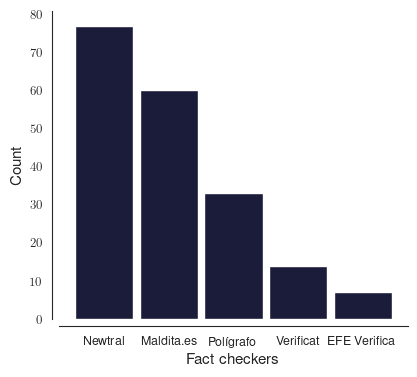

In [17]:
field = 'fact_checker'

# Define the colour for the fact-checker to be coherent
colours_fact_checker = define_colours(df_iberifier, field)

# Get the counts
field_counts = get_values_count(df_iberifier, field)

# Get per days
field_dates, field_dates_norm = output_df_for_cross(df_iberifier, 'date', field, reorder_first=False, reorder_second=True)

# Get the table
## Save the table
#field_counts.to_csv(f"./tables/{sample}_proportion_{field}.csv")

# Get the plot
filename, fig, ax = plot_counts(field_counts, field)
ax.set_xlabel('Fact checkers')
## Save the plot

# Output the table
field_counts

## Qualification of claim

,qualification,Counts,Percentages
0,Falso,124,64.9
1,Verdadero / Verdadeiro,24,12.6
2,Explainer,22,11.5
3,Engañoso / Enganador,13,6.8
4,No verificable / Não verificável,4,2.1
5,Manipulado,4,2.1


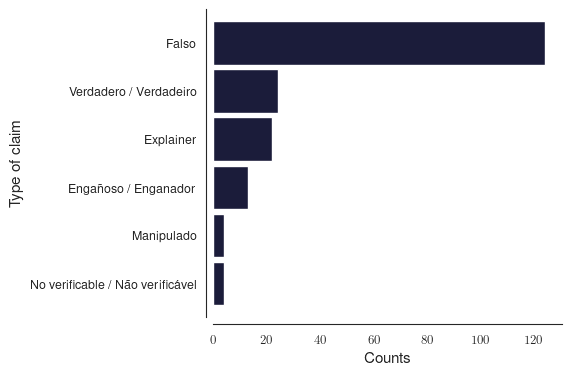

In [18]:
field = 'qualification'

# Define the colour for the fact-checker to be coherent
colours_qualification_claims = define_colours(df_iberifier, field)

# Get the counts
field_counts = get_values_count(df_iberifier, field)

# Get per days
field_dates, field_dates_norm = output_df_for_cross(df_iberifier, 'date', field, reorder_first=False, reorder_second=True)

# Get the table
## Save the table
#field_counts.to_csv(f"./tables/{sample}_proportion_{field}.csv")

# Get the plot
filename, fig, ax = plot_counts(field_counts, field, kind_bar='barh')
ax.set_ylabel('Type of claim')
ax.set_xlabel('Counts')

## Save the plot

# Output the table
field_counts

## Source of Claim

,sources,Counts,Percentages
0,Twitter,81,28.9
1,Facebook,77,27.5
2,Otros / Outros,63,22.5
3,WhatsApp,27,9.6
4,TikTok,20,7.1
5,Telegram,5,1.8
6,Buscador,4,1.4
7,Instagram,3,1.1


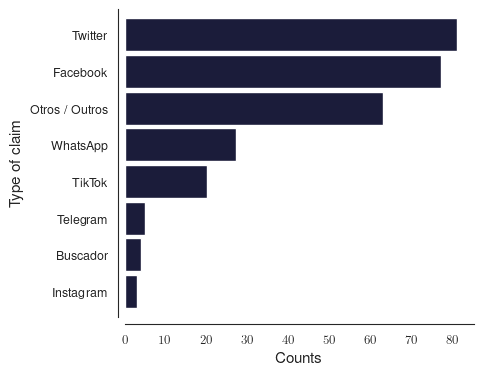

In [19]:
field = 'sources'

# Define the colour for the fact-checker to be coherent
#colours_source_claims = define_colours(df_iberifier, field)

# Get the counts
field_counts = get_values_count(df_iberifier, field)

# Get per days
field_dates, field_dates_norm = output_df_for_cross(df_iberifier, 'date', field, reorder_first=False, reorder_second=True)

# Get the table
## Save the table
#field_counts.to_csv(f"./tables/{sample}_proportion_{field}.csv")

# Get the plot
filename, fig, ax = plot_counts(field_counts, field, kind_bar='barh')
ax.set_ylabel('Type of claim')
ax.set_xlabel('Counts')

## Save the plot

# Output the table
field_counts

## Fact checker and Qualification of claims

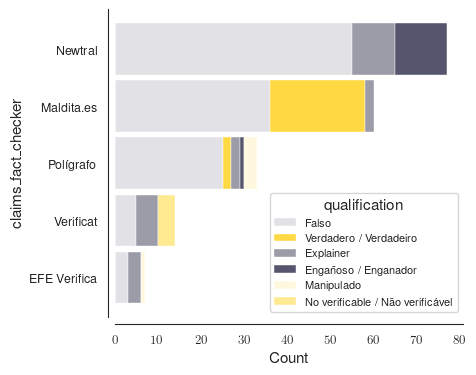

In [20]:
# Setting up the variable for the plot
field1 = 'fact_checker'
field2 = 'qualification'
color_palette = colours_qualification_claims
df_to_plot, df_to_plot_norm = output_df_for_cross(df_iberifier, field1, field2)

# Generating the plot
filename, ax = plot_cross(df_to_plot, field1, field2, color_palette,  width_bar=0.9, norm=False)

## Source and Qualification of claims

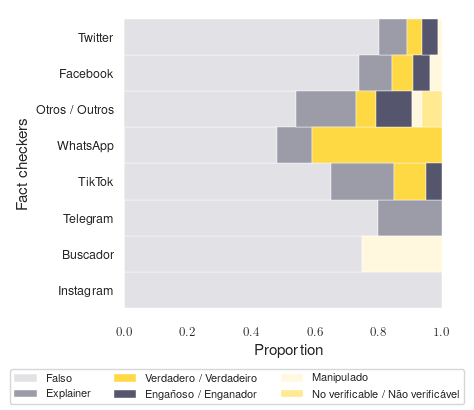

In [21]:
# Setting up the variables for the plot
field1 = 'sources'
field2 = 'qualification'
color_palette = colours_qualification_claims
df_to_plot, df_to_plot_norm = output_df_for_cross(df_iberifier, field1, field2)

# Generating the plot
fig, ax = plt.subplots(layout='constrained')

filename, ax = plot_cross(df_to_plot_norm, field1, field2, colours=color_palette, norm=True,  ax=ax)
fig.legend(loc='outside lower center', ncol=3)
ax.legend().remove()
ax.set_ylabel('Fact checkers')
ax.set_xlabel('Proportion')
plt.show()

## Category and Qualification of claims

In [22]:
field1 = 'categories'

field2 = 'qualification'
color_palette = colours_qualification_claims


df_to_plot, df_to_plot_norm = output_df_for_cross(df_iberifier, field1, field2)

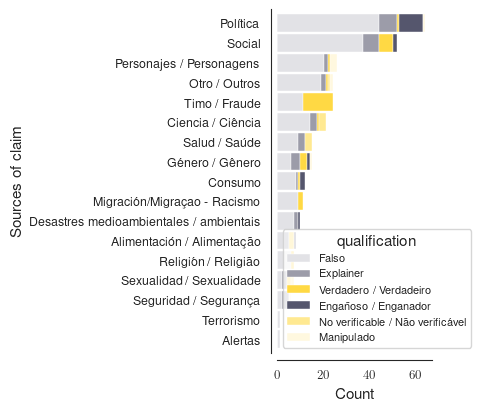

In [23]:
fig, ax = plt.subplots(layout='constrained')

filename, ax = plot_cross(df_to_plot, field1, field2, color_palette,  width_bar=0.9, norm=False, ax=ax)
ax.set_ylabel('Sources of claim')
plt.show()

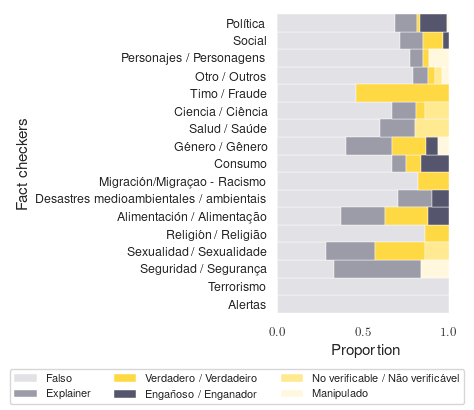

In [24]:
# Generating the plot
fig, ax = plt.subplots(figsize=(4.5, 4), layout='constrained')

filename, ax = plot_cross(df_to_plot_norm, field1, field2, colours=color_palette, norm=True,  ax=ax)
fig.legend(loc='outside lower center', ncol=3)
ax.legend().remove()
ax.set_ylabel('Fact checkers')
ax.set_xlabel('Proportion')

plt.show()

# Experiment subset

## Overview

In [25]:
datasources = ['Claims','News',  'Tweets' ]
df_overview = pd.DataFrame({'Data source': datasources, 'Dataset': ['All']*3, 'Counts': eval_count})
df_overview#.plot(kind='bar')

,Data source,Dataset,Counts
0,Claims,All,94
1,News,All,1319
2,Tweets,All,71598


In [26]:
datasources = ['Claims','News',  'Tweets', ]
df_overview = pd.DataFrame({'Data source': datasources*2, 'Dataset': ['All']*3 +['Experiment subset']*3, 'Counts': all_count+eval_count})
table = df_overview.pivot(index='Data source', columns='Dataset', values='Counts')
table['Difference'] = table['All'] - table['Experiment subset']
table

Dataset,All,Experiment subset,Difference
Data source,,,
Claims,191,94,97
News,1563,1319,244
Tweets,115873,71598,44275


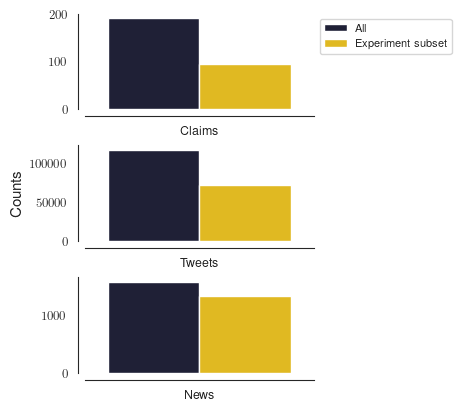

In [27]:
# define the subplots
fig, ax = plt.subplots(3, layout='constrained')

sns.despine(offset=5, trim=False)

# plot each line in a separate subplot
sns.barplot(data=df_overview[df_overview['Data source'] == 'Claims'], x='Data source', y='Counts', hue='Dataset',  ax=ax[0], palette=[main_color, second_color])
sns.barplot(data=df_overview[df_overview['Data source'] == 'Tweets'], x='Data source', y='Counts', hue='Dataset',  ax=ax[1], palette=[main_color, second_color])
sns.barplot(data=df_overview[df_overview['Data source'] == 'News'], x='Data source', y='Counts', hue='Dataset',  ax=ax[2], palette=[main_color, second_color])
# add titles and axis labels
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')


# Removing y-axis labels
ax[0].set_ylabel('')
#ax[1].set_ylabel('')
ax[2].set_ylabel('')

#fig.legend(loc='outside lower center', ncol=2)
ax[0].legend().remove()
ax[1].legend().remove()
ax[2].legend().remove()
ax[0].legend(bbox_to_anchor=(1,1), loc="upper left")

filename = f'overview_subsets'
#save_plot(fig, ax, filename, 'all')
plt.show()

# Topic relation

In [102]:
tweets_topic_count.unstack().to_frame()


0
topic_relation off-topic  84516
               on-topic   23730

KeyError: 'Counts'

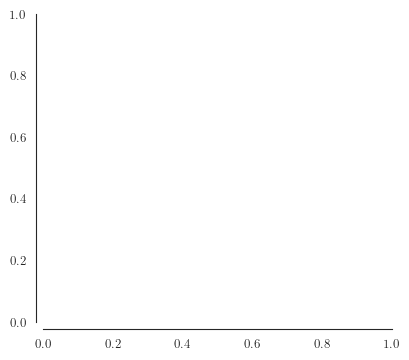

In [97]:
tweets_topic_count  = df_tweets['topic_relation'].value_counts().to_frame()
tweets_topic_count

# Get the plot
filename, fig, ax = plot_counts(tweets_topic_count, 'topic_relation', kind_bar='barh')
ax.set_ylabel('Type of claim')
ax.set_xlabel('Counts')

## Save the plot
tweets_topic_count


In [29]:
df_mynews['topic_relation'].value_counts()

off-topic    642
on-topic     521
Name: topic_relation, dtype: int64

# On Topic

# On claim 

In [65]:
#Only using on-topic
tweets_exploded = df_tweets[df_tweets['topic_relation'] == 'on-topic'].explode('fact_id')

### Using dates

In [66]:
# Get the number of fact_id per tweets
df_tweets['nbr_facts'] = df_tweets['fact_id'].apply(lambda x: len(x))
# Explode tweets on fact_id list
#tweets_exploded = df_tweets.explode('fact_id')

iberifier_columns = ['date', 'time', 'sources', 'fact_id', 'categories', 'type', 'fact_checker', 'qualification']
# Merge the iberifier onto the tweets based on the fact_id
tweets_iberifier = pd.merge(tweets_exploded, df_iberifier[iberifier_columns], on='fact_id', how='left')

# Rename the date to avoid confusion
tweets_iberifier = tweets_iberifier.rename(columns={'date_x': 'date_tweet', 'date_y': 'date_fact_check', 'time_x': 'time_tweet', 'time_y': 'time_fact_check'})
len(tweets_iberifier)

24117

In [67]:
# Calculate the difference in time between the time the tweet is published and the fact-check
tweets_iberifier['diff_date'] = (tweets_iberifier['date_tweet'] - tweets_iberifier['date_fact_check']).dt.days
tweets_iberifier['diff_date'] = tweets_iberifier['diff_date'].fillna(0)
tweets_iberifier['diff_date'] = tweets_iberifier['diff_date'].astype('int') 

# Groupby and get the impact size for each of fact_id - Fill nan with 0 as it means nothing was collected before

                                                                                                  
             
# Create the diff date for the plot
diff_date = tweets_iberifier.groupby(['fact_id', 'diff_date']).size().reset_index()
diff_date_per_factchecker = tweets_iberifier.groupby(['fact_id', 'diff_date', 'fact_checker']).size().reset_index()[['diff_date', 'fact_checker', 0]]
diff_date_per_support_claim = tweets_iberifier.groupby(['fact_id', 'diff_date', 'claim_finer_relation']).size().reset_index()[['diff_date', 'claim_finer_relation', 0]]

## Grouping by tweets metrics
diff_date_metrics = tweets_iberifier.groupby(['fact_id', 'diff_date']).agg({'retweet_count': 'mean', 
                                                              'reply_count': 'mean', 
                                                              'like_count': 'mean',
                                                              'quote_count': 'mean',
                                                              'impression_count': 'mean'})

diff_date_metrics_support_claim = tweets_iberifier.groupby(['fact_id', 'diff_date', 'claim_finer_relation']).agg({'retweet_count': 'mean', 
                                                              'reply_count': 'mean', 
                                                              'like_count': 'mean',
                                                              'quote_count': 'mean',
                                                              'impression_count': 'mean'})

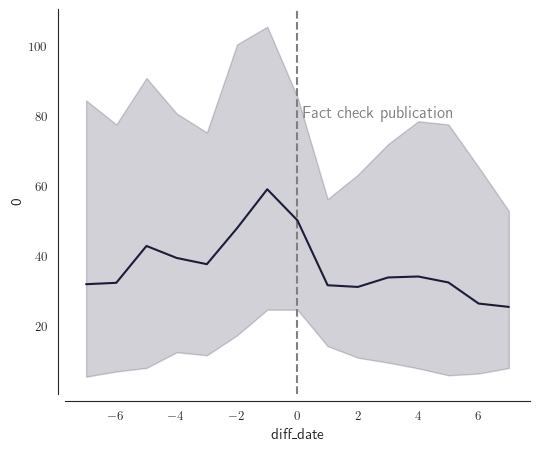

In [68]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(6, 5))

sns.despine(offset=5, trim=False)
ax.axvline(x=0, color='grey', linestyle='--')
ax = sns.lineplot(diff_date, x='diff_date', y=0, color=main_color)
ax.text(x=2.7, y=ax.get_ylim()[1]-ax.get_ylim()[1]/4, s='Fact check publication', fontsize=12, color='grey', bbox={'boxstyle': 'round,pad=0.3', 'ec': 'none', 'fc': 'none'}, ha='center', va='top' )
filename = f'impact_tweets_line_all'
#save_plot(fig, ax, filename)

Text(2.7, 33.950390625, 'Fact check publication')

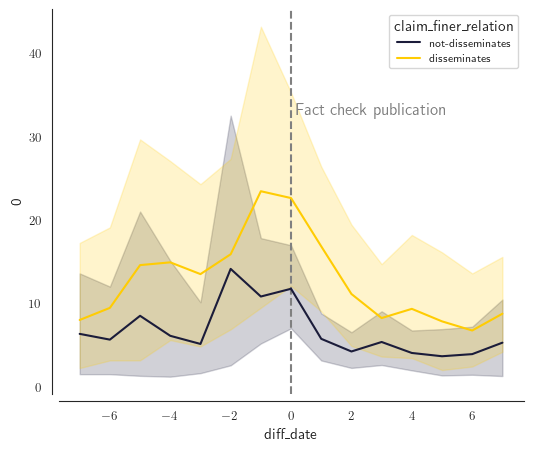

In [69]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(6, 5))
sns.despine(offset=5, trim=False)
ax.axvline(x=0, color='grey', linestyle='--')

ax = sns.lineplot(diff_date_per_support_claim, x='diff_date', hue='claim_finer_relation', y=0, palette=[main_color, second_color])
ax.text(x=2.7, y=ax.get_ylim()[1]-ax.get_ylim()[1]/4, s='Fact check publication', fontsize=12, color='grey', bbox={'boxstyle': 'round,pad=0.3', 'ec': 'none', 'fc': 'none'}, ha='center', va='top' )

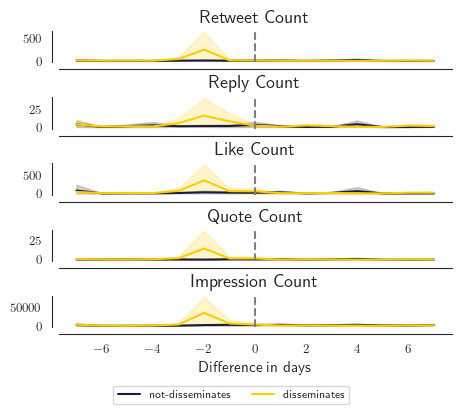

In [78]:
# define the subplots
fig, ax = plt.subplots(5,  sharex=True, layout='constrained')

sns.despine(offset=5, trim=False)

# plot each line in a separate subplot
sns.lineplot(data=diff_date_metrics_support_claim, x='diff_date', y='retweet_count', hue='claim_finer_relation', palette=[main_color, second_color], ax=ax[0])
sns.lineplot(data=diff_date_metrics_support_claim, x='diff_date', y='reply_count', hue='claim_finer_relation', palette=[main_color, second_color], ax=ax[1], legend=None)
sns.lineplot(data=diff_date_metrics_support_claim, x='diff_date', y='like_count', hue='claim_finer_relation',palette=[main_color, second_color],  ax=ax[2], legend=None)
sns.lineplot(data=diff_date_metrics_support_claim, x='diff_date', y='quote_count', hue='claim_finer_relation',palette=[main_color, second_color], ax=ax[3], legend=None)
sns.lineplot(data=diff_date_metrics_support_claim, x='diff_date', y='impression_count', hue='claim_finer_relation',palette=[main_color, second_color], ax=ax[4], legend=None)


# Draw line for the event
ax[0].axvline(x=0, ymax=ax[0].get_ylim()[1]/2, color='grey', linestyle='--')
ax[1].axvline(x=0, ymax=ax[1].get_ylim()[1]/2, color='grey', linestyle='--')
ax[2].axvline(x=0, ymax=ax[2].get_ylim()[1]/2, color='grey', linestyle='--')
ax[3].axvline(x=0, ymax=ax[3].get_ylim()[1]/2, color='grey', linestyle='--')
ax[4].axvline(x=0, ymax=ax[4].get_ylim()[1]/2, color='grey', linestyle='--')

# add titles and axis labels
ax[0].set_title('Retweet Count')
ax[1].set_title('Reply Count')
ax[2].set_title('Like Count')
ax[3].set_title('Quote Count')
ax[4].set_title('Impression Count')

# Removing y-axis labels
ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[3].set_ylabel('')
ax[4].set_ylabel('')

# Set the xlabel
ax[4].set_xlabel('Difference in days')

fig.legend(loc='outside lower center', ncol=2)
ax[0].legend().remove()
plt.show()

In [70]:
### Using hours

In [104]:
# Calculate the difference in time between the time the tweet is published and the fact-check
tweets_iberifier['diff_time'] = (tweets_iberifier['time_tweet'] - tweets_iberifier['time_fact_check']).astype('timedelta64[h]')
tweets_iberifier['diff_time'] = pd.to_timedelta(tweets_iberifier['diff_time'], unit='h')
# Create the diff date for the plot
diff_time = tweets_iberifier.groupby(['fact_id', 'diff_time']).size().reset_index()
diff_time_per_factchecker = tweets_iberifier.groupby(['fact_id', 'diff_time', 'fact_checker']).size().reset_index()[['diff_time', 'fact_checker', 0]]
diff_time_per_support_claim = tweets_iberifier.groupby(['fact_id', 'diff_time', 'claim_finer_relation']).size().reset_index()[['diff_time', 'claim_finer_relation', 0]]

## Grouping by tweets metrics
diff_time_metrics = tweets_iberifier.groupby(['fact_id', 'diff_time']).agg({'retweet_count': 'mean', 
                                                              'reply_count': 'mean', 
                                                              'like_count': 'mean',
                                                              'quote_count': 'mean',
                                                              'impression_count': 'mean'})

diff_time_metrics_support_claim = tweets_iberifier.groupby(['fact_id', 'diff_time', 'claim_finer_relation']).agg({'retweet_count': 'mean', 
                                                              'reply_count': 'mean', 
                                                              'like_count': 'mean',
                                                              'quote_count': 'mean',
                                                              'impression_count': 'mean'})

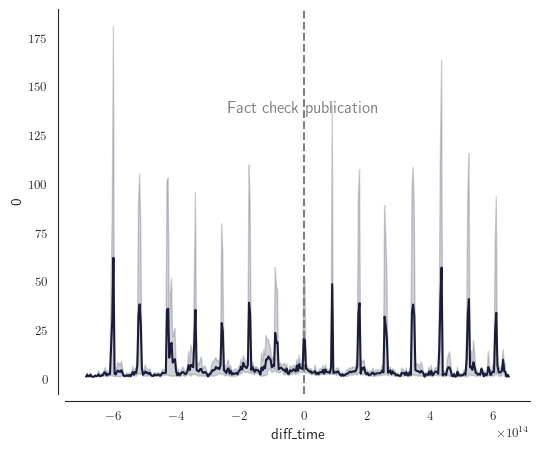

In [72]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(6, 5))

sns.despine(offset=5, trim=False)
ax.axvline(x=0, color='grey', linestyle='--')
ax = sns.lineplot(diff_time, x='diff_time', y=0, color=main_color)
ax.text(x=2.7, y=ax.get_ylim()[1]-ax.get_ylim()[1]/4, s='Fact check publication', fontsize=12, color='grey', bbox={'boxstyle': 'round,pad=0.3', 'ec': 'none', 'fc': 'none'}, ha='center', va='top' )
filename = f'impact_tweets_line_all'
#save_plot(fig, ax, filename)

Text(0, 59.025000000000006, 'Fact check publication')

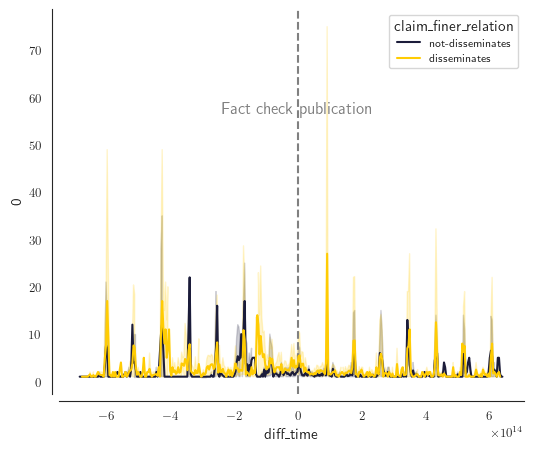

In [89]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(6, 5))
sns.despine(offset=5, trim=False)
ax.axvline(x=0, color='grey', linestyle='--')

ax = sns.lineplot(diff_time_per_support_claim, x='diff_time', hue='claim_finer_relation', y=0, palette=[main_color, second_color])
ax.text(x=0, y=ax.get_ylim()[1]-ax.get_ylim()[1]/4, s='Fact check publication', fontsize=12, color='grey', bbox={'boxstyle': 'round,pad=0.3', 'ec': 'none', 'fc': 'none'}, ha='center', va='top' )

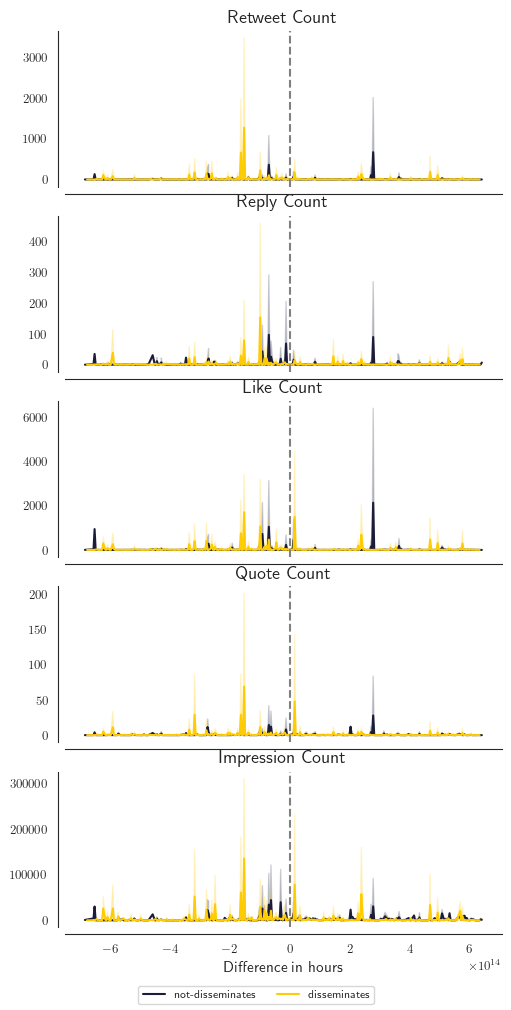

In [81]:
# define the subplots
fig, ax = plt.subplots(5,  sharex=True, layout='constrained', figsize=(5, 10))

sns.despine(offset=5, trim=False)

# plot each line in a separate subplot
sns.lineplot(data=diff_time_metrics_support_claim, x='diff_time', y='retweet_count', hue='claim_finer_relation', palette=[main_color, second_color], ax=ax[0])
sns.lineplot(data=diff_time_metrics_support_claim, x='diff_time', y='reply_count', hue='claim_finer_relation', palette=[main_color, second_color], ax=ax[1], legend=None)
sns.lineplot(data=diff_time_metrics_support_claim, x='diff_time', y='like_count', hue='claim_finer_relation',palette=[main_color, second_color],  ax=ax[2], legend=None)
sns.lineplot(data=diff_time_metrics_support_claim, x='diff_time', y='quote_count', hue='claim_finer_relation',palette=[main_color, second_color], ax=ax[3], legend=None)
sns.lineplot(data=diff_time_metrics_support_claim, x='diff_time', y='impression_count', hue='claim_finer_relation',palette=[main_color, second_color], ax=ax[4], legend=None)


# Draw line for the event
ax[0].axvline(x=0, ymax=ax[0].get_ylim()[1]/2, color='grey', linestyle='--')
ax[1].axvline(x=0, ymax=ax[1].get_ylim()[1]/2, color='grey', linestyle='--')
ax[2].axvline(x=0, ymax=ax[2].get_ylim()[1]/2, color='grey', linestyle='--')
ax[3].axvline(x=0, ymax=ax[3].get_ylim()[1]/2, color='grey', linestyle='--')
ax[4].axvline(x=0, ymax=ax[4].get_ylim()[1]/2, color='grey', linestyle='--')

# add titles and axis labels
ax[0].set_title('Retweet Count')
ax[1].set_title('Reply Count')
ax[2].set_title('Like Count')
ax[3].set_title('Quote Count')
ax[4].set_title('Impression Count')

# Removing y-axis labels
ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[3].set_ylabel('')
ax[4].set_ylabel('')

# Set the xlabel
ax[4].set_xlabel('Difference in hours')

fig.legend(loc='outside lower center', ncol=2)
ax[0].legend().remove()
plt.show()